### Перцептрон в задаче классификации

In [11]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import torch
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = map(torch.from_numpy, list(train_test_split(X, y, train_size=0.5, shuffle=True)))

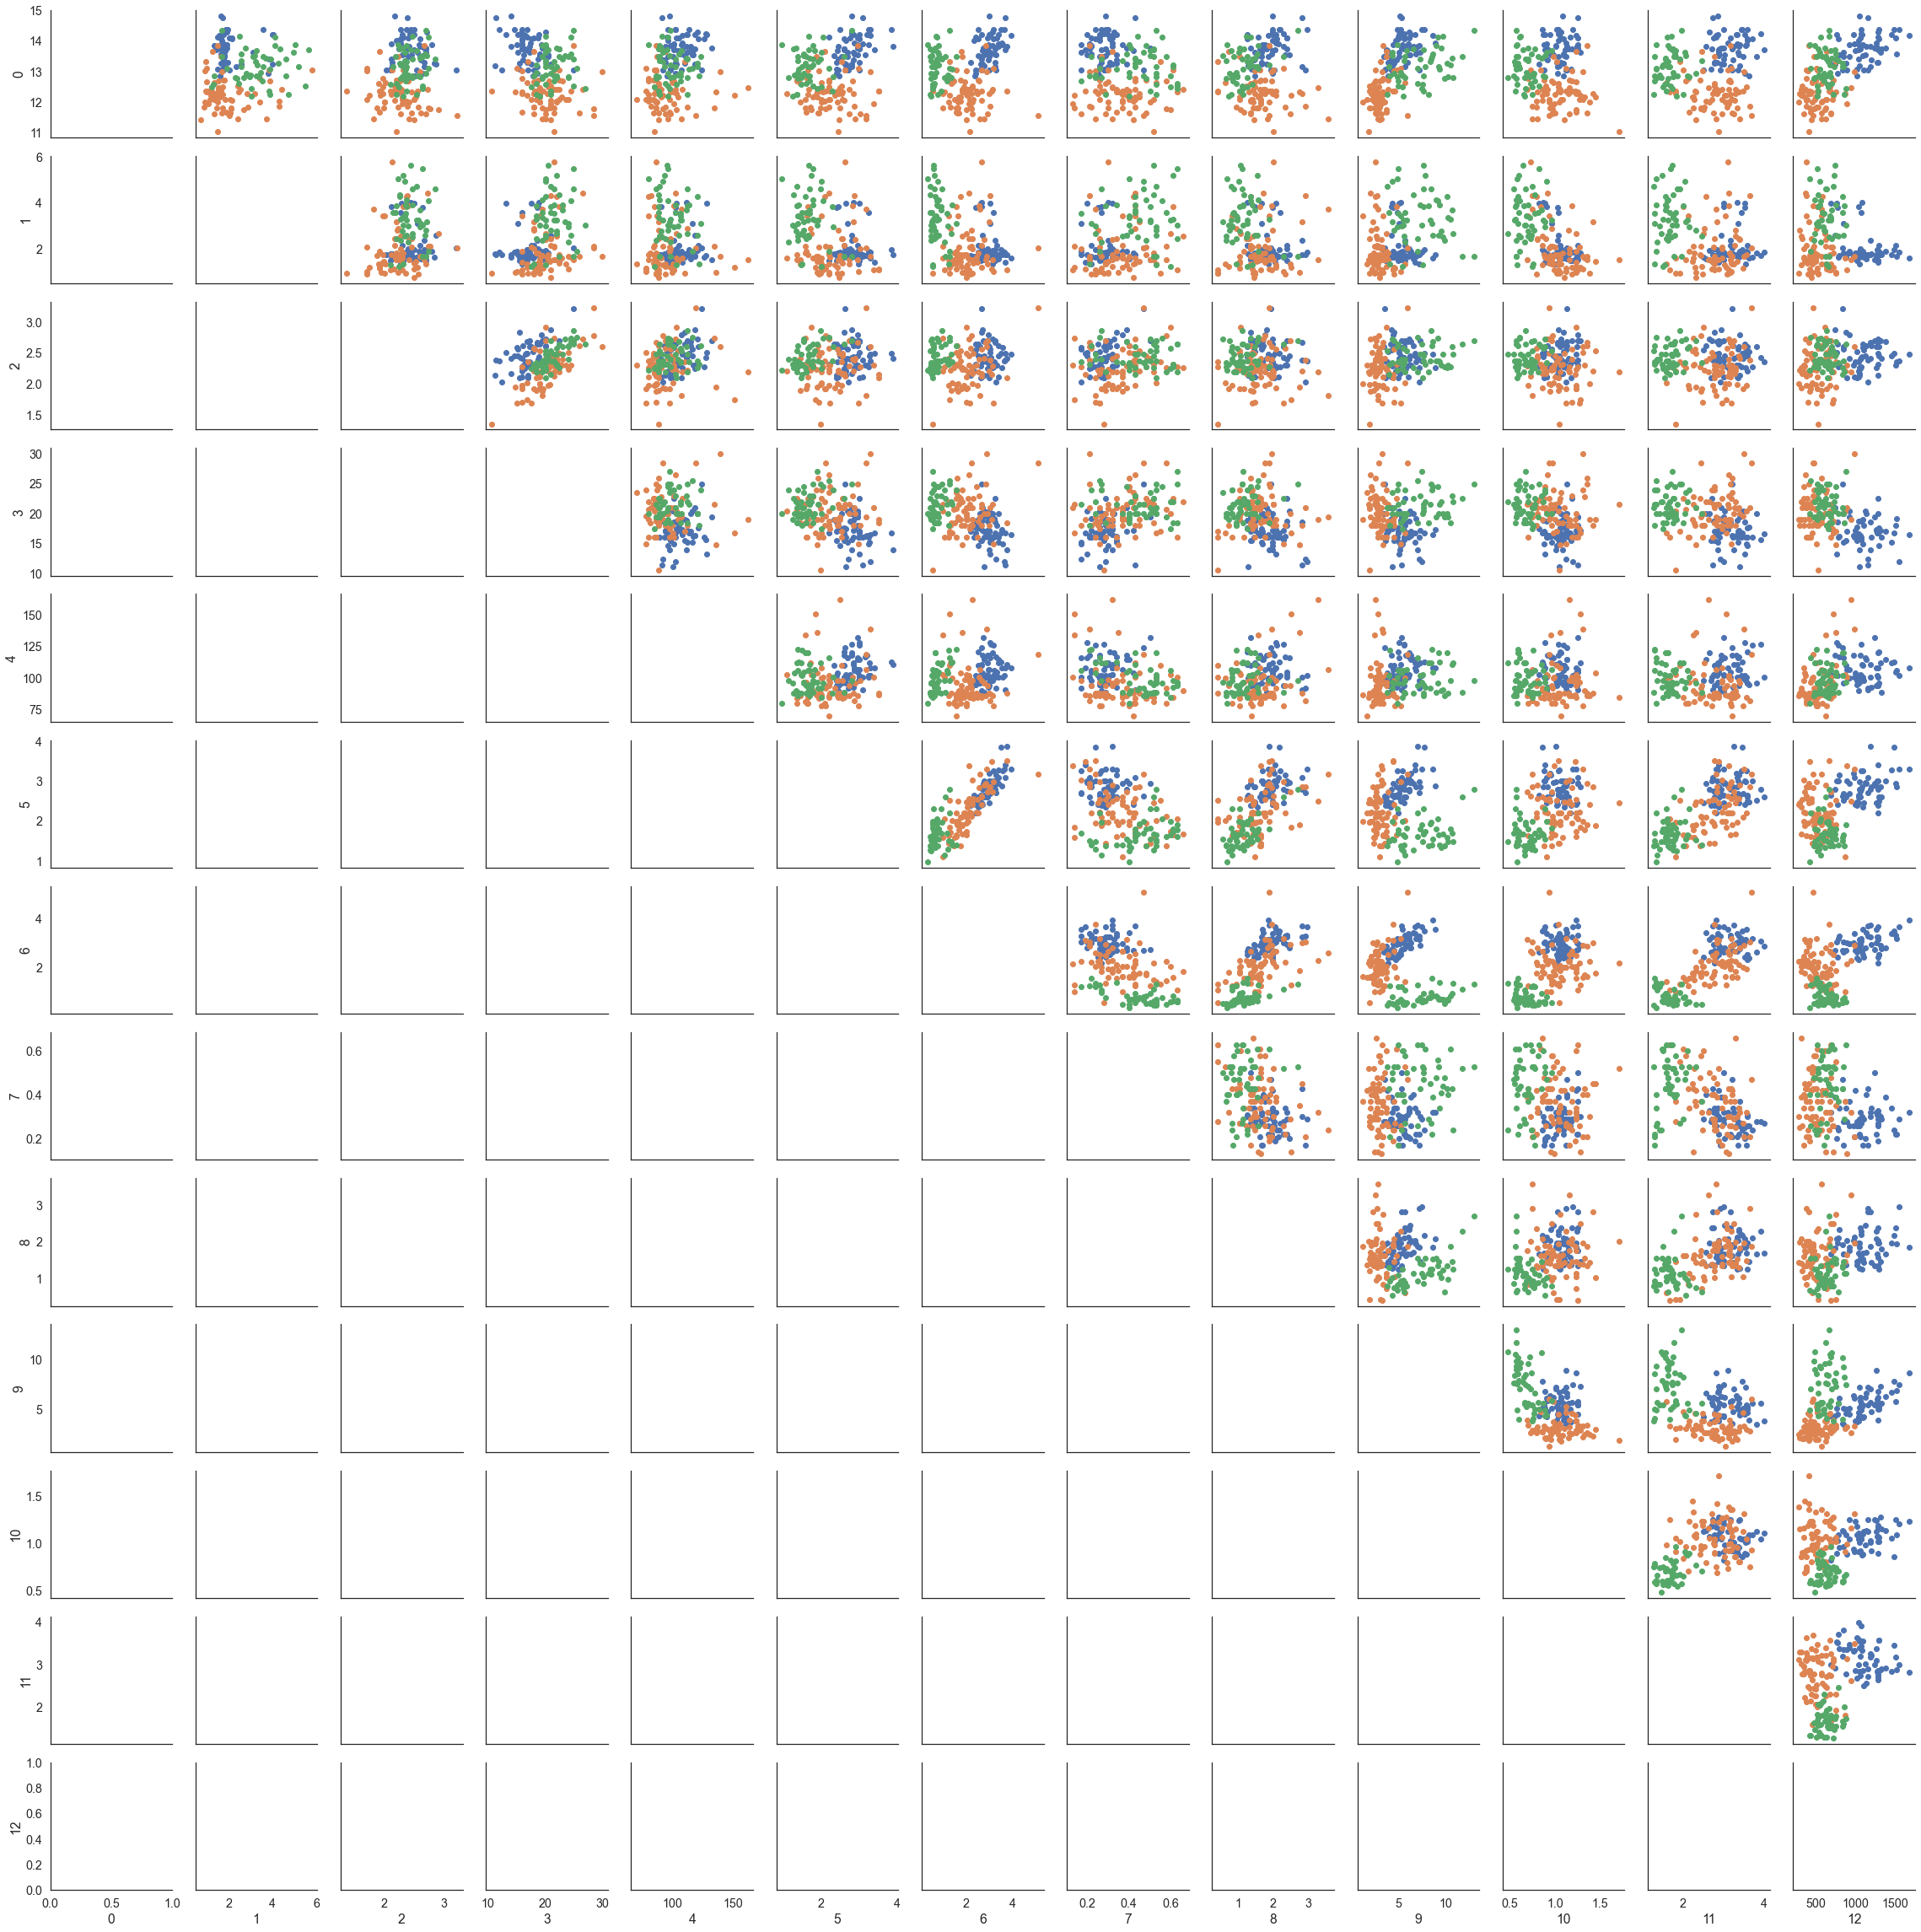

In [13]:

sns.set(style='white', font_scale=1.3)
df = pd.DataFrame(X)
df['class'] = y
g = sns.PairGrid(df, hue='class')
g.map_upper(plt.scatter)

In [14]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=13, num_layers=2,
                 hidden_dim=13, output_dim=3, p=0.0):
        super(Perceptron, self).__init__()

        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim

        self.layers.add_module('classifier',
                               torch.nn.Linear(prev_size, output_dim))

    def forward(self, input):
        return self.layers(input)

In [15]:
model = Perceptron()
model = model.to(torch.float)

In [16]:
def final_testing(model, data, target):
    pred = []
    real = []

    for x, y in zip(data, target):
        x = x.to(torch.float)
        x = x.view([-1, 13])
        y = y.view([1])
        y = y.to(torch.long)
        pred.extend(torch.argmax(model(x), dim=-1).numpy().tolist())
        real.extend(y.numpy().tolist())

    return classification_report(pred, real)


def accuracy_testing(model, data, target):
    pred = []
    real = []

    for x, y in zip(data, target):
        x = x.to(torch.float)
        x = x.view([-1, 13])
        y = y.view([1])
        y = y.to(torch.long)
        pred.extend(torch.argmax(model(x), dim=-1).numpy().tolist())
        real.extend(y.numpy().tolist())

    return accuracy_score(pred, real)

In [17]:
def trainer(model, data, target, loss_function, optimizer, epochs):
    for epoch in range(epochs):

        for x, y in zip(data, target):
            optimizer.zero_grad()
            x = x.to(torch.float)
            x = x.view([-1, 13])
            y = y.view([1])
            y = y.to(torch.long)
            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [43]:
param_grid = list(ParameterGrid({'epochs': [30, 35, 40, 45, 50, 55],
                                 'hidden_dim': [3, 7, 9, 11, 13]}))
accuracies = []
for params in param_grid:
    model = Perceptron(hidden_dim=params['hidden_dim'])
    model.train()
    trainer(model=model,
            data=X_train,
            target=y_train,
            loss_function=torch.nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
            epochs=params['epochs'])
    model.eval()
    accuracies.append(accuracy_testing(model, X_test, y_test))
params = param_grid[np.argmax(np.array(accuracies))]
params

{'epochs': 55, 'hidden_dim': 13}

In [46]:
model = Perceptron(hidden_dim=params['hidden_dim'])
model.train()
trainer(model=model, data=X_train,
        target=y_train, loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=params['epochs'])
model.eval()
report = final_testing(model, X_test, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        27
           1       1.00      0.85      0.92        33
           2       0.97      1.00      0.98        29

    accuracy                           0.94        89
   macro avg       0.95      0.95      0.94        89
weighted avg       0.95      0.94      0.94        89

